In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path

data_folder = Path().absolute() / "../data/processed/"
file_name = "combined_df.csv"

# check file size
file_size_bytes = (data_folder / file_name).stat().st_size
print(f"The file size in bytes is: {file_size_bytes: 1G}")

The file size in bytes is:  2.41221E+06


## Load Data

In [2]:
df = pd.read_csv(
    data_folder / file_name,
    parse_dates=["DateTime"],
    )
df.head(10)

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,DateTime
0,Saturday,LAWRENCE EAST STATION,SRDP,0,0,N,SRT,3023,2022-01-01 15:59:00
1,Saturday,SPADINA BD STATION,MUIS,0,0,NaN,BD,0,2022-01-01 02:23:00
2,Saturday,KENNEDY SRT STATION TO,MRO,0,0,NaN,SRT,0,2022-01-01 22:00:00
3,Saturday,VAUGHAN MC STATION,MUIS,0,0,NaN,YU,0,2022-01-01 02:28:00
4,Saturday,EGLINTON STATION,MUATC,0,0,S,YU,5981,2022-01-01 02:34:00
5,Saturday,QUEEN STATION,MUNCA,0,0,NaN,YU,0,2022-01-01 05:40:00
6,Saturday,DAVISVILLE STATION,MUNCA,0,0,NaN,YU,0,2022-01-01 06:56:00
7,Saturday,ST PATRICK STATION,MUNCA,0,0,NaN,YU,0,2022-01-01 06:58:00
8,Saturday,PAPE STATION,MUNCA,0,0,NaN,BD,0,2022-01-01 07:01:00
9,Saturday,WILSON STATION,TUATC,10,0,S,YU,5896,2022-01-01 07:43:00


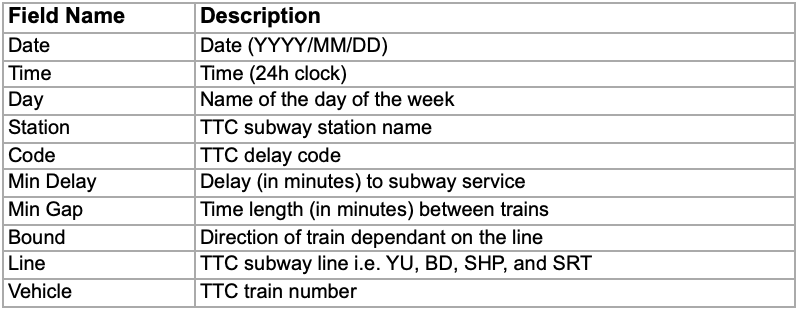

1. What days have the most number of delays, what is the average delay? 
2. Which station has the most number of delays, what is the average delay?
3. Which delay code is used most?
4. What Line has the most delays?
5. Are there any train numbers that have more delays?

# Initial Data Analysis

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37620 entries, 0 to 37619
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Day        37620 non-null  object        
 1   Station    37620 non-null  object        
 2   Code       37620 non-null  object        
 3   Min Delay  37620 non-null  int64         
 4   Min Gap    37620 non-null  int64         
 5   Bound      25881 non-null  object        
 6   Line       37541 non-null  object        
 7   Vehicle    37620 non-null  int64         
 8   DateTime   37620 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 2.6+ MB


# Top 5 worst performing
The categories we need to analyse are Stations, Code Bound, Line and Vehicles.
For example, the worst performing stations are important to understand so we can flag these and dive deeper into the data in why.

Additional categories that would benefit from analysis include: Day of Week, Hour of Day, Month, Year. From this we can determine when delays are likely to occur.

### Metrics

To establish which stations are the worst performing it is crucial to understand how we can compare each of the categories.

##### On Time performance
An obvious metric is percentage of [**on-time performance**](https://en.wikipedia.org/wiki/On-time_performance), which can be calculated as services on time divided by total services. 

In [4]:
def calculate_metrics(sub_category: pd.DataFrame) -> pd.Series:
    metrics = {}
    no_delay_count = sub_category[sub_category["Min Delay"] == 0].shape[0]
    total_service_count = sub_category.shape[0]
    
    # return 0 if there are no on-time services
    if (no_delay_count == 0):
        sub_category["on_time_perc_performance"] = 0.

    metrics["on_time_perc_performance"] = no_delay_count * 100/total_service_count
    metrics["total_service_count"] = total_service_count
    metrics["total_delay"] = sub_category["Min Delay"].sum()

    return pd.Series(metrics)
    


The function above has been moved to `src/analyse.py` file.

##### Total delay time

The other metric should be the total delay, which is calculated by the sum of delayed minutes. 